In this notebook, we'll use a pre-trained machine learning model to generate a submission to the [BirdClef2023 competition](https://www.kaggle.com/c/birdclef-2023).  The goal of the competition is to identify Eastern African bird species by sound.

## Step 1: Imports

In [2]:
# Install All libraries
!pip install -Uq fastcore fastai fastbook
!pip install image_tabular
!pip install kaggle
! [ -e /content ] && pip install -Uqq pip fastai git+https://github.com/drscotthawley/fastproaudio.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import files, drive
drive.mount("/content/gdrive")
# Switch do DeepLearning directory
%cd /content/gdrive/MyDrive/DeepLearning

Mounted at /content/gdrive
/content/gdrive/MyDrive/DeepLearning


In [4]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import random
import glob
import matplotlib.pyplot as plt
from typing import List

import csv
import io

import os

from IPython.display import Audio

import torchaudio
import torch
import torchvision.transforms as T


# To save spectrograms as png
import skimage.io

# fastproaudio
from fastproaudio.core import *


# Fastai
import fastbook
fastbook.setup_book()
from fastbook import *
from fastcore.transform import Transform
from fastai.torch_core import TensorBase
from fastai.data.core import TensorImageBase

# Import all the vision library
from fastai.vision.all import *


In [7]:
# Setup kaggle API

# 1. Read the kaggle API token to interact with your kaggle account
# Folder containing kaggle.json for kaggle API authorization
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/DeepLearning/"

In [8]:
!ls
# Pick a path to download the dataset to:
comp = 'birdclef-2023'
path = URLs.path(comp)
path_train = Path(path/'train_audio')

kaggle.json	      XC263486.npy  XC390403.npy  XC488964.npy	XC617034.npy
path_spectrogram      XC264285.npy  XC390404.npy  XC489212.npy	XC617406.npy
soundscape_29201.npy  XC264287.npy  XC390406.npy  XC489247.npy	XC617653.npy
XC110322.npy	      XC264908.npy  XC390503.npy  XC489638.npy	XC617797.npy
XC112589.npy	      XC264914.npy  XC390545.npy  XC490124.npy	XC617953.npy
XC113258.npy	      XC265022.npy  XC390694.npy  XC490718.npy	XC618254.npy
XC113550.npy	      XC265023.npy  XC390729.npy  XC492092.npy	XC618620.npy
XC115075.npy	      XC265153.npy  XC390804.npy  XC492093.npy	XC618866.npy
XC115261.npy	      XC265154.npy  XC390821.npy  XC492095.npy	XC619303.npy
XC115262.npy	      XC265217.npy  XC391601.npy  XC492174.npy	XC619322.npy
XC115400.npy	      XC265261.npy  XC391989.npy  XC492311.npy	XC619369.npy
XC115649.npy	      XC265433.npy  XC391995.npy  XC492913.npy	XC619384.npy
XC116030.npy	      XC265563.npy  XC392004.npy  XC492937.npy	XC619392.npy
XC116031.npy	      XC265769.npy  XC392045.npy 

In [15]:
#And use the Kaggle API to download the dataset to that path, and extract it:
Path.BASE_PATH = path

from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 4.91G/4.91G [03:53<00:00, 22.6MB/s]


(#3) [Path('train_metadata.csv'),Path('eBird_Taxonomy_v2021.csv'),Path('sample_submission.csv')]

# Pre-generate Spectrograms and save them
Generate spectrograms over 5-seconds splits of resampled audio files


In [16]:
Path(path/'train_audio/gybfis1').ls()

(#10) [Path('train_audio/gybfis1/XC131985.ogg'),Path('train_audio/gybfis1/XC127885.ogg'),Path('train_audio/gybfis1/XC282058.ogg'),Path('train_audio/gybfis1/XC397814.ogg'),Path('train_audio/gybfis1/XC282061.ogg'),Path('train_audio/gybfis1/XC282065.ogg'),Path('train_audio/gybfis1/XC618866.ogg'),Path('train_audio/gybfis1/XC267529.ogg'),Path('train_audio/gybfis1/XC396326.ogg'),Path('train_audio/gybfis1/XC267528.ogg')]

Get the paths to all audio files

In [10]:
def get_audio_files(path):
    return get_files(path, extensions='.ogg', recurse=True)

def get_npy_files(path):
    return get_files(path, extensions='.npy', recurse=True)


In [11]:
def read_signal(audio_file_path: Path,
                  audio_split_length: float=5.,
                  audio_hop_length: float=1.,
                  sample_rate: int=32000):
    # Load audio sample from file path
    sig, rate = librosa.load(audio_file_path)    
    # Resample to match desired sample rate
    resampled_sig = librosa.resample(sig, orig_sr=rate, target_sr=sample_rate)
    return resampled_sig.astype(float, copy=False)

def split_signal(resampled_sig: np.ndarray,
                  audio_split_length: float=5.,
                  audio_hop_length: float=1.,
                  sample_rate: int=32000):
    "Split signal into chunks of desired length. Returns a list a those chunks" 

    len_chunk = int(audio_split_length*sample_rate)
    len_sig = len(resampled_sig)

    # If length of signal inferior to desired length, pad it with zeros
    if (len_sig <= len_chunk):
      res = np.zeros(len_chunk)
      res[:len_sig] = resampled_sig
      return [res]
    else:
      res = []
      # Create chunks. To avoid padding, the last chunk will start audio_split_length seconds before the signal end.
      start = 0
      hop = int(sample_rate*audio_hop_length)

      while(start+len_chunk <= len_sig):
        res.append(resampled_sig[start:start+len_chunk])
        start+=hop

    # Append last chunk
      res.append(resampled_sig[len_sig-len_chunk:])

      return res


def truncate_window(signal: np.ndarray,
                  window_size=10.,
                  sample_rate: int=32000):
    "Truncate signal within a random window of desired length" 

    length_window = int(window_size*sample_rate)
    len_signal = len(signal)
    if (len_signal>=length_window):
        start_window = random.randint(0,len_signal-length_window) 
        window = signal[start_window:start_window+length_window]
        return [window]
    else:
        window = np.zeros(length_window)
        window[0:len_signal] = signal
        return [window]


In [12]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def create_spectrogram(path_save, signal:np.ndarray, sample_rate:int=32000):
    spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate)#, n_fft=int(duration*sample_rate))
    # save file
    np.save(path_save, spec)  


In [13]:
def save_chunk_as_file(chunk, audio_file_path: Path, sample_rate:int=32000, extension:str='.npy', idx_chunk=0, split=False):
    if split==True:
      path_save = Path(audio_file_path.parent/(audio_file_path.stem+f"-{idx_chunk}"+extension))
    else:
      path_save = Path(audio_file_path.parent/(audio_file_path.stem+extension))

    if not path_save.exists():
      create_spectrogram(path_save, chunk, sample_rate)
      print(path_save)
    else:
      print(path_save)
      print("LAST ALREADY EXISTED")
    return idx_chunk + 1

def create_spectrograms(audio_file_path: Path,
                        truncate_window_bool=False,
                        window_size=10.,
                        split=False,
                        audio_split_length: float=5.,
                        audio_hop_length: float=1.,
                        sample_rate: int=32000,
                        ax=None,
                        vmin=-70,
                        vmax=0,
                        rate=32000,
                        ctx=None):
    "Create all spectrograms for one audio file and save them in the same folder as audio files"
    # Split signal in to desired length chunks or window
    signal = read_signal(audio_file_path, audio_split_length=audio_split_length, audio_hop_length=audio_hop_length, sample_rate=sample_rate) 

    if truncate_window_bool==True:
      chunks = truncate_window(signal, window_size=window_size,sample_rate=sample_rate)

    elif split==True:
      chunks = split_signal(audio_file_path, audio_split_length=audio_split_length, audio_hop_length=audio_hop_length, sample_rate=sample_rate) 
    else:
      chunks=[signal]

    for i, chunk in enumerate(chunks):
        save_chunk_as_file(chunk, audio_file_path, idx_chunk=i)

## Call the methods and save spectrograms as .npy files

In [13]:
len(audio_files) 

16942

In [14]:
for i, audio_file in enumerate(audio_files):
  create_spectrograms(audio_file, truncate_window_bool=True)
  print(f"\nPROCESSED AUDIO FILES : {i} / {len(audio_files)}\n") # Output progress

Streaming output truncated to the last 5000 lines.
/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC305790.npy

PROCESSED AUDIO FILES : 15692 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC343720.npy

PROCESSED AUDIO FILES : 15693 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC745664.npy

PROCESSED AUDIO FILES : 15694 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC56577.npy

PROCESSED AUDIO FILES : 15695 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC270260.npy

PROCESSED AUDIO FILES : 15696 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC401374.npy

PROCESSED AUDIO FILES : 15697 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC590999.npy

PROCESSED AUDIO FILES : 15698 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC247549.npy

PROCESSED AUDIO FILES : 15699 / 16942

/root/.fastai/archive/birdclef-2023/train_audio/gyhneg1/XC530145.npy

PROCESSE

#### Play sound to alert when long task is over

# TRAIN LEARNER


Extract Labels from csv file

In [17]:
# Extract labels from submission csv
labels_csv_path = path/"sample_submission.csv"

def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    with open(class_map_csv_text) as csv_file:

        csv_reader = csv.reader(csv_file, delimiter=',')
        class_names = csv_reader.__next__()
        # Return all columns headers except for the first one which is "rows"
        return class_names[1:]

# Put all bird ids into labels list
labels_vocab = class_names_from_csv(labels_csv_path)

Write function to show spectrograms

In [18]:
def show_spectrogram(audio_data, ax=None, vmin=-70, vmax=0, rate=32000, ctx=None):
    # Get audio tensor (values between 0. and 1.) and convert to spectrogram DB values
    spec_db = array(audio_data[0]*255)

    # Plot Mel-spectrogram plot, from librosa documentation
    if ax is None: fig, ax = plt.subplots()
    img = librosa.display.specshow(spec_db, y_axis='mel', x_axis='time', ax=None, sr=32000, vmin=-70, vmax=0)
    ax.set(title=f'Spectrogram of bird type : {audio_data[1]}')
    plt.colorbar(img, ax=ax, format="%+2.f dB")
    if ax is None: plt.show(block=False)

# Before we can create a Transform, we need a type that knows how to show itself
# (if we want to use the show method). Here we define a TitledImage:
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs):
      show_spectrogram(self, ctx=ctx, **kwargs)

Write transform to feed .npy spectrogram files to learner

In [84]:
# Function to convert .npy files into tensors
def npy_to_tensor(path_file:Path):
    # Load file
    spec = np.load(path_file)
    # Convert to DB
    spec_db = librosa.power_to_db(spec, ref=np.max)
    # Convert spectrogram DB data to PyTorch Tensor
    spec_tensor = tensor(spec_db).float()/255
    return spec_tensor

transform = transforms.Compose([transforms.ToTensor()])


class NpyTransform(ItemTransform):
    def setups(self, items):
      self.lblr = parent_label
      vals = class_names_from_csv(labels_csv_path)
      self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): 
      return (T.ToPILImage(npy_to_tensor(o)), self.o2i[self.lblr(o)])
    def decodes(self, x): 
      return TitledImage(transform(x[0]),self.vocab[x[1]])

def NpyBlock(vocab, o2i, lblr):
    return TransformBlock(type_tfms=NpyTransform(vocab, o2i, lblr))


In [20]:
items = get_npy_files(path)
audio_items = get_audio_files(path)
len(items), len(audio_items)

(0, 16942)

In [ ]:
# Check for double occurences of name files
for i, audio_file_path in enumerate(audio_items):
  print(i)
  count = 0
  for audio_file_path2 in audio_items:
    if audio_file_path.name == audio_file_path2.name:
      count += 1
      if count == 2:
        print("DOUBLON")
        print(audio_file_path.name)
        print(audio_file_path2.name)
        break

In [22]:
# Save npy files to google drive
#for i, path_file in enumerate(items):
#  path_tmp = Path("/content/gdrive/MyDrive/DeepLearning/"+path_file.name)
#  shutil.copy(path_file, path_tmp) 
#  print(f'Copied Items : {i}/{len(items)}')


In [60]:
audio_items[1]

Path('train_audio/vilwea1/XC421902.ogg')

In [ ]:
# Add parent folders to npy files in gdrive
path_npy_gdrive = Path("/content/gdrive/MyDrive/DeepLearning/")
path_ogg_fastai = Path('/root/.fastai/archive/birdclef-2023/train_audio/')
for i, path_npy in enumerate(items):
  print(f'Processing {i+1}/{len(items)}')
  for path_ogg in audio_items:
    if path_npy.stem == path_ogg.stem:
      dest = Path(path_npy_gdrive/path_ogg.parent.name/path_npy.name)
      # Check if directory exists
      if not dest.parent.exists():
        dest.parent.mkdir(parents=True, exist_ok=True)
      shutil.move(path_npy, dest)
      break

In [72]:
!ls /content/gdrive/MyDrive/DeepLearning/


abethr1  blhgon1  bswdov1  gryapa1	meypar1  refcro1  trobou1  yebduc1
afecuc1  bltori1  carcha1  gybfis1	nobfly1  refwar2  vibsta2  yebere1
afmdov1  brctch1  chewea1  gycwar3	palfly2  rerswa1  vilwea1  yesbar1
afrgrp1  brobab1  cohmar1  hamerk1	piecro1  sccsun2  whbcan1
bawman1  brrwhe3  gabgos2  kaggle.json	ratcis1  scrcha1  whctur2
beasun2  brtcha1  gnbcam2  loceag1	rebfir2  soucit1  wookin1
blaplo1  brubru1  gobbun1  lotcor1	reboxp1  strsee1  yebapa1


In [63]:
path_ogg = audio_items[1]
path_npy_gdrive = Path("/content/gdrive/MyDrive/DeepLearning/")
path_npy = items[1]
Path(path_npy_gdrive/path_ogg.parent.name/path_npy.name)

Path('/content/gdrive/MyDrive/DeepLearning/vilwea1/XC681392.npy')

## Test transform class and functions

In [ ]:
labeller = parent_label
vals = list(map(labeller, items))
vocab,o2i = uniqueify(vals, sort=True, bidir=True)
npy_transform = NpyTransform(vocab,o2i,labeller)

In [ ]:
x,y = npy_transform(items[0])
x.shape, y


In [ ]:
(x,y)

In [ ]:
dec = npy_transform.decode([x,y])
dec.show()

## Create Tfmdlists

In [74]:
path_npy_gdrive = Path("/content/gdrive/MyDrive/DeepLearning/")
items = get_npy_files(path_npy_gdrive)
items

(#2736) [Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC380521.npy'),Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC681392.npy'),Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC391989.npy'),Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC158287.npy'),Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC703041.npy'),Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC170277.npy'),Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC634131.npy'),Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC581949.npy'),Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC537108.npy'),Path('/content/gdrive/MyDrive/DeepLearning/sccsun2/XC545260.npy')...]

In [88]:
# Parameters of the TfmdLists
npy_transform = NpyTransform()
npy_transform.setup(items)
splits = RandomSplitter()(items)


In [76]:
items[0]
items[0].exists()

True

In [77]:
vals = class_names_from_csv(labels_csv_path)
vocab, o2i = uniqueify(vals, sort=True, bidir=True)
parent_label(items[0])
o2i[parent_label(items[0])]

191

In [78]:
x,y = npy_transform(items[0])
x.shape, y

/content/gdrive/MyDrive/DeepLearning/sccsun2/XC380521.npy


(torch.Size([128, 626]), 191)

In [89]:
tls = TfmdLists(items, [npy_transform], splits=splits)


In [100]:
dls = tls.dataloaders(bs=64)


In [91]:
from torchvision.models import resnet34, resnet50
opt_func = partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8)

In [124]:
dblock = DataBlock(blocks = (TransformBlock(NpyTransform()), CategoryBlock),
                   get_items = get_npy_files,
                   get_y=parent_label,
                   splitter = RandomSplitter())

In [120]:
!ls /content/gdrive/MyDrive/DeepLearning


abethr1  blhgon1  bswdov1  gryapa1	meypar1  refcro1  trobou1  yebduc1
afecuc1  bltori1  carcha1  gybfis1	nobfly1  refwar2  vibsta2  yebere1
afmdov1  brctch1  chewea1  gycwar3	palfly2  rerswa1  vilwea1  yesbar1
afrgrp1  brobab1  cohmar1  hamerk1	piecro1  sccsun2  whbcan1
bawman1  brrwhe3  gabgos2  kaggle.json	ratcis1  scrcha1  whctur2
beasun2  brtcha1  gnbcam2  loceag1	rebfir2  soucit1  wookin1
blaplo1  brubru1  gobbun1  lotcor1	reboxp1  strsee1  yebapa1


rerswa1
bswdov1


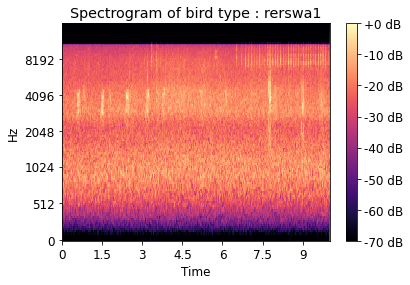

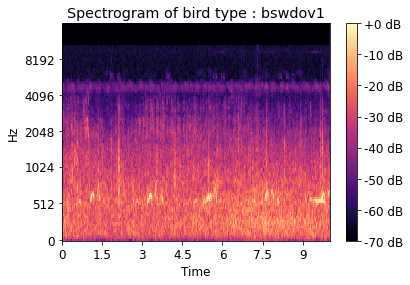

In [125]:
dls = dblock.dataloaders(path_npy_gdrive, bs=64)
dls.show_batch(max_n=2)


In [92]:

# define learner and train model
learn = vision_learner(dls, resnet18, opt_func=opt_func,metrics=error_rate, loss_func=CrossEntropyLossFlat)


In [ ]:
LE LEANER NE MARCHE PAS SANS DOUTE CAR FASTAI EST PARAMETRé POUR LES PILImage. Tenter de convertir le tensor en PILimage avant de lancer le training
https://www.tutorialspoint.com/how-to-convert-a-torch-tensor-to-pil-image

In [126]:
learn = vision_learner(tls, resnet18, metrics=error_rate, loss_func=CrossEntropyLossFlat)
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time


TypeError: ignored

In [ ]:
 from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)